In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
load_dotenv()
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",task_type="retrieval_query")
vector = embeddings.embed_query("my name is aniket, madarchod")
print(len(vector))



768


In [4]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [8]:
#you can create your own documnet here
"""from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load example document
with open("state_of_art_union.txt") as f:
    state_of_the_union = f.read()

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=50,
    chunk_overlap=10,
    length_function=len,
    is_separator_regex=False,
)
texts = text_splitter.create_documents([state_of_the_union],
                                       metadatas=[{"source": "state_of_art_union.txt"}])
texts=texts[:10]
"""

In [5]:
from langchain_core.documents import Document
docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "dishes.txt"},
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"},
    ),
]


In [10]:
docs2=[
    Document(page_content="my name is aniket",metadata={"source":"aniket.txt"}),
]


In [10]:
print(len(texts)) #41 documents created here 

10


In [6]:
db=Chroma.from_documents(docs, embeddings)
retriever=db.as_retriever(search_kwargs={"k": 4})

In [7]:
retriever.invoke("what is the name of the hotel?")

[Document(id='166ece77-caa4-4876-bccf-b126c5c7f8e6', metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.'),
 Document(id='82e78601-67a0-4ab4-a42d-de01ec9686ff', metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.'),
 Document(id='a4af7783-f7e4-4fa3-ba51-0cd500c220e4', metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.'),
 Documen

In [8]:
retriever.invoke("what is the boys name")

[Document(id='166ece77-caa4-4876-bccf-b126c5c7f8e6', metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.'),
 Document(id='f2d421ef-8be7-49eb-8dea-20d3bdedc487', metadata={'source': 'dishes.txt'}, page_content='Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.'),
 Document(id='a4af7783-f7e4-4fa3-ba51-0cd500c220e4', metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.'),
 Document(id='82e78601-67a0-4ab4-a42d-de01ec9686ff', metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista offers a variety of menus including a

In [13]:
from langchain_core.prompts import ChatPromptTemplate

template="""Answer the question based only on the following context:
{context}
Question: {question}"""
promp=ChatPromptTemplate.from_template(template)


In [15]:
promp.pretty_print() #you can pull this from hub also 

================================ Human Message =================================

Answer the question based only on the following context:
{context}
Question: {question}


In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.chat_models import init_chat_model

llm = init_chat_model("google_genai:gemini-2.0-flash")
prompt=hub.pull("rlm/rag-prompt")

prompt.pretty_print()

def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

qa_chain=(
    {"context":retriever|format_docs,
     "question":RunnablePassthrough(),}
     |prompt
     |llm
     |StrOutputParser()
)

qa_chain.invoke("what is my name?")

c:\projects\LangGraph\venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


'Your name is Aniket. I found this information in the provided context. I hope this helps!'

In [25]:
qa_chain.invoke("what is the name of the restaurant?")

'The name of the restaurant is Bella Vista. It offers a variety of menus including lunch, dinner, and a special weekend brunch. It is open seven days a week.'

In [26]:
qa_chain.invoke("opening time of the restaurant?")

'Bella Vista is open Monday to Sunday from 11:00 AM to 10:00 PM on weekdays and 11:00 AM to 11:00 PM on weekends.'

## RAG Agent

In [13]:
retriever

VectorStoreRetriever(tags=['Chroma', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x0000020019833CD0>, search_kwargs={'k': 4})

In [27]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.chat_models import init_chat_model

llm = init_chat_model("google_genai:gemini-2.0-flash")
prompt=hub.pull("rlm/rag-prompt")
rag_chain=prompt|llm|StrOutputParser()

c:\projects\LangGraph\venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [28]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, BaseMessage, HumanMessage
from langchain_core.documents import Document

class AgentState(TypedDict):
    messages:list[BaseMessage]
    document:list[Document]
    on_topic:str


In [29]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """Boolean value to check weather the question is related to the restaurant or not"""
    score:str=Field(
        description="Question is about restaurant? if yes -> yes, if no -> no"
        )
def question_classifier(state: AgentState):
    question = state["messages"][-1].content

    system = """You are a classifier that determines whether a user's question is about one of the following topics:

    1. Information about the owner of Bella Vista, which is Antonio Rossi.
    2. Prices of dishes at Bella Vista (restaurant).
    3. Opening hours of Bella Vista (restaurant).

    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'. Remember, ONLY YES or NO, nothing else in the reponse!
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )
    llm = init_chat_model("google_genai:gemini-2.0-flash")
    structured_llm=llm.with_structured_output(GradeQuestion)
    grader_llm=grade_prompt|structured_llm
    grade=grader_llm.invoke({"question":question})
    state["on_topic"]=grade.score
    return state


In [30]:
def on_topic_router(state:AgentState):
    on_topic=state["on_topic"]
    if on_topic.lower()=="yes":
        return "on_topic"
    else:
        return "off_topic"
    
def retriver(state:AgentState):
    question=state["messages"][-1].content
    documents=retriever.invoke(question)
    state["document"]=documents
    return state

def get_answer(state:AgentState):
    question=state["messages"][-1].content
    documents=state["document"]
    generation=rag_chain.invoke({"context":documents,"question":question})
    state["messages"].append(generation)
    return state

def off_topic_response(state:AgentState):
    state["messages"].append(AIMessage(content="I'm sorry, I can only answer questions about the topic of the hotels."))
    return state


In [35]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, BaseMessage, HumanMessage,AIMessage

workflow=StateGraph(AgentState)

workflow.add_node("topic_decision",question_classifier)
workflow.add_node("retriver",retriver)
workflow.add_node("off_topic_response",off_topic_response)
workflow.add_node("get_answer",get_answer)

workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,{
        "on_topic":"retriver",
        "off_topic":"off_topic_response"
    },
    )
workflow.add_edge(START,"topic_decision")
workflow.add_edge("retriver","get_answer")
workflow.add_edge("get_answer",END)
workflow.add_edge("off_topic_response",END)

graph=workflow.compile()



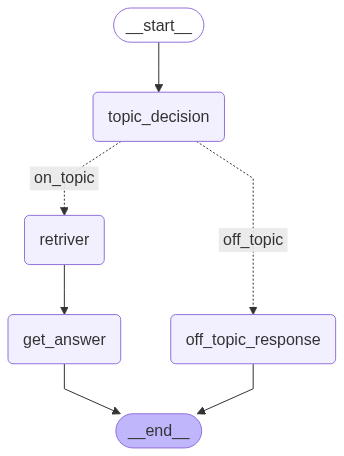

In [36]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        ))
)

In [37]:
graph.invoke(input={"messages":[HumanMessage(content="What is the menu for the weekend brunch?")]})

{'messages': [HumanMessage(content='What is the menu for the weekend brunch?', additional_kwargs={}, response_metadata={}),
  'The weekend brunch menu includes both classic breakfast items and Italian specialties. Bella Vista offers a special weekend brunch menu in addition to lunch and dinner menus. The restaurant is open on weekends from 11:00 AM to 11:00 PM.'],
 'document': [Document(id='82e78601-67a0-4ab4-a42d-de01ec9686ff', metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.'),
  Document(id='166ece77-caa4-4876-bccf-b126c5c7f8e6', metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 

In [38]:
graph.invoke(input={"messages":[HumanMessage(content="what is artificial intelligence?")]})

{'messages': [HumanMessage(content='what is artificial intelligence?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry, I can only answer questions about the topic of the conversation.", additional_kwargs={}, response_metadata={})],
 'on_topic': 'no'}